In [22]:
# Import necessary libraries
import optuna
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

In [23]:
# Load data from CSV
file_path = "/kaggle/input/parkinson-full/parkinsons_updrs.data" 
data = pd.read_csv(file_path)


# Scale the data (important for DBSCAN)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

In [24]:
# Define the objective function for Optuna
def objective(trial):
    # Suggest values for eps and min_samples
    eps = trial.suggest_float("eps", 0.1, 2.0)  # Adjust the range based on your data
    min_samples = trial.suggest_int("min_samples", 2, 10)  # Adjust the range based on your data
    
    # Apply DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(data_scaled)
    
    # Calculate Silhouette Score (only if there are more than 1 cluster)
    if len(np.unique(labels)) > 1:
        return silhouette_score(data_scaled, labels)
    else:
        return -1  # Return a bad score if all points are noise or only one cluster

# Create an Optuna study and optimize
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# Print the best parameters and score
print("Best parameters:", study.best_params)
print("Best Silhouette Score:", study.best_value)

[I 2025-02-22 12:27:32,172] A new study created in memory with name: no-name-5ca15a67-a681-47b0-ae9c-ea35c46df849
[I 2025-02-22 12:27:32,650] Trial 0 finished with value: -0.13062348765208737 and parameters: {'eps': 1.083875194838971, 'min_samples': 7}. Best is trial 0 with value: -0.13062348765208737.
[I 2025-02-22 12:27:33,113] Trial 1 finished with value: -0.49704789976818203 and parameters: {'eps': 0.5785856475414536, 'min_samples': 3}. Best is trial 0 with value: -0.13062348765208737.
[I 2025-02-22 12:27:33,545] Trial 2 finished with value: -0.31229606262773113 and parameters: {'eps': 0.8948714003650311, 'min_samples': 6}. Best is trial 0 with value: -0.13062348765208737.
[I 2025-02-22 12:27:33,985] Trial 3 finished with value: -0.018198039773440807 and parameters: {'eps': 1.336123086118175, 'min_samples': 10}. Best is trial 3 with value: -0.018198039773440807.
[I 2025-02-22 12:27:34,426] Trial 4 finished with value: -0.1204727027847556 and parameters: {'eps': 1.1769989348741288, 

Best parameters: {'eps': 1.9991095908862553, 'min_samples': 5}
Best Silhouette Score: 0.08186017511167598


In [25]:
# Apply DBSCAN with the best parameters
best_eps = study.best_params["eps"]
best_min_samples = study.best_params["min_samples"]
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
labels = dbscan.fit_predict(data_scaled)


In [26]:
# Add cluster labels to the original data
data["Cluster"] = labels

# Print the clustered data
print("Clustered Data:")
print(data)

Clustered Data:
      subject#  age  sex  test_time  motor_UPDRS  total_UPDRS  Jitter(%)  \
0            1   72    0     5.6431       28.199       34.398    0.00662   
1            1   72    0    12.6660       28.447       34.894    0.00300   
2            1   72    0    19.6810       28.695       35.389    0.00481   
3            1   72    0    25.6470       28.905       35.810    0.00528   
4            1   72    0    33.6420       29.187       36.375    0.00335   
...        ...  ...  ...        ...          ...          ...        ...   
5870        42   61    0   142.7900       22.485       33.485    0.00406   
5871        42   61    0   149.8400       21.988       32.988    0.00297   
5872        42   61    0   156.8200       21.495       32.495    0.00349   
5873        42   61    0   163.7300       21.007       32.007    0.00281   
5874        42   61    0   170.7300       20.513       31.513    0.00282   

      Jitter(Abs)  Jitter:RAP  Jitter:PPQ5  ...  Shimmer:APQ3  Shimmer:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


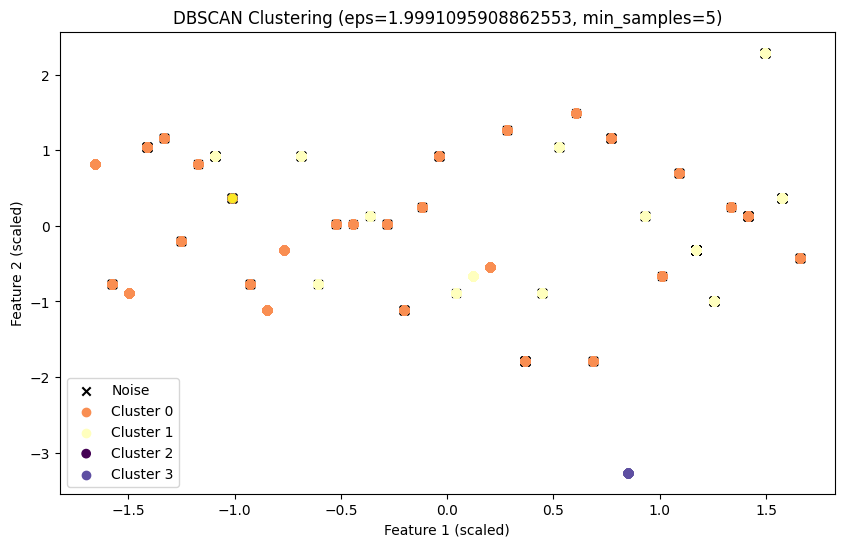

In [27]:
# Plot the clusters
plt.figure(figsize=(10, 6))
unique_labels = np.unique(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

for label, color in zip(unique_labels, colors):
    if label == -1:
        # Plot noise points in black
        plt.scatter(data_scaled[labels == label, 0], data_scaled[labels == label, 1], 
                    c="black", marker="x", label="Noise")
    else:
        # Plot clustered points
        plt.scatter(data_scaled[labels == label, 0], data_scaled[labels == label, 1], 
                    c=color, marker="o", label=f"Cluster {label}")

plt.title(f"DBSCAN Clustering (eps={best_eps}, min_samples={best_min_samples})")
plt.xlabel("Feature 1 (scaled)")
plt.ylabel("Feature 2 (scaled)")
plt.legend()
plt.show()